<a href="https://colab.research.google.com/github/Mariyselita/CIP/blob/main/Algoritmos_de_clasificaci%C3%B3n_TAREA_9_CIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filepath = '/content/drive/My Drive/CIP/Datos/'

In [ ]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


# Cargar los datasets
ciclones_df = pd.read_csv(filepath + 'Ciclones.csv', encoding='latin1')
clima_extremo_df = pd.read_csv(filepath + 'Clima_Extremo.csv', encoding='latin1')
incendios_forestales_df = pd.read_csv(filepath + 'Incendios_Forestales.csv', encoding='latin1')
sequias_df = pd.read_csv(filepath + 'Sequias.csv', encoding='latin1')
sismos_df = pd.read_csv(filepath + 'Sismos.csv', encoding='latin1')

# Función para verificar y balancear los datasets
def balance_dataset(df, target_column):
    class_counts = df[target_column].value_counts()

    if len(class_counts) < 2:
        print(f"El dataset solo tiene una clase. No se puede balancear.")
        return None

    majority_count = class_counts.max()
    balanced_df = pd.DataFrame()

    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]
        if len(df_label) < majority_count:
            df_label = resample(df_label, replace=True, n_samples=majority_count, random_state=42)
        balanced_df = pd.concat([balanced_df, df_label])

    return balanced_df

# Balancear los datasets
datasets_balanced = {
    "Ciclones": balance_dataset(ciclones_df, 'Gravedad'),
    "Clima Extremo": balance_dataset(clima_extremo_df, 'Gravedad'),
    "Incendios Forestales": balance_dataset(incendios_forestales_df, 'Gravedad'),
    "Sequías": balance_dataset(sequias_df, 'Gravedad'),
    "Sismos": balance_dataset(sismos_df[sismos_df['Magnitud'] >= 3.5], 'Gravedad')
}

# Filtrar los datasets que no pudieron ser balanceados
datasets_balanced = {k: v for k, v in datasets_balanced.items() if v is not None}

# Determinar el tamaño del dataset más pequeño después del filtrado
min_size = min([len(df) for df in datasets_balanced.values()])

# Balancear todos los datasets al tamaño mínimo
balanced_datasets_final = {
    name: resample(df, replace=False, n_samples=min_size, random_state=42) for name, df in datasets_balanced.items()
}

# Guardar los datasets balanceados en archivos CSV
for name, df in balanced_datasets_final.items():
    df.to_csv(filepath + f'balanced_{name}.csv', index=False)

# Mostrar la distribución de clases en los datasets balanceados finales
for name, df in balanced_datasets_final.items():
    print(f"Dataset: {name}")
    print(df['Gravedad'].value_counts())
    print("\n")

# Función para preprocesar los datos
def preprocess_data(df, target_column):
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Convertir las etiquetas a valores numéricos
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Identificar las columnas categóricas
    categorical_columns = X.select_dtypes(include=['object']).columns

    # Asegurarse de que las columnas categóricas no tengan valores numéricos mezclados
    for col in categorical_columns:
        X[col] = X[col].astype(str)

    # Definir el preprocesador
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), X.select_dtypes(exclude=['object']).columns),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_columns)
        ])

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Aplicar el preprocesador
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, X_test, y_train, y_test

# Función para clasificar y evaluar los modelos
def classify_and_evaluate(X_train, X_test, y_train, y_test):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Random Forest": RandomForestClassifier()
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Model: {name}")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
        print("\n")

# Preprocesar y clasificar los datasets balanceados
for name, df in balanced_datasets_final.items():
    print(f"Resultados para {name}")
    X_train, X_test, y_train, y_test = preprocess_data(df, 'Gravedad')
    classify_and_evaluate(X_train, X_test, y_train, y_test)
    print("\n")


Dataset: Ciclones
Gravedad
Fuerte         86
Medio          84
Bajo           82
Desconocido    76
Name: count, dtype: int64


Dataset: Clima Extremo
Gravedad
Bajo      164
Fuerte    164
Name: count, dtype: int64


Dataset: Incendios Forestales
Gravedad
Bajo      117
Fuerte    114
Medio      97
Name: count, dtype: int64


Dataset: Sequías
Gravedad
Medio     114
Fuerte    109
Bajo      105
Name: count, dtype: int64


Dataset: Sismos
Gravedad
Bajo     166
Medio    162
Name: count, dtype: int64


Resultados para Ciclones
Model: Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        17

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Accuracy: 1.0


Resultados para Ciclones
Model: Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        17

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Accuracy: 1.0


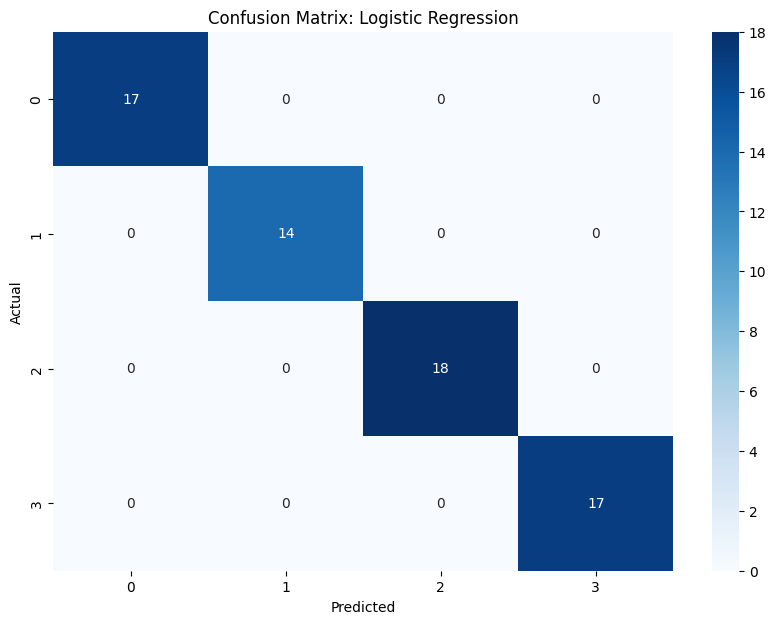



Model: K-Nearest Neighbors
              precision    recall  f1-score   support

           0       1.00      0.71      0.83        17
           1       0.78      1.00      0.88        14
           2       0.90      1.00      0.95        18
           3       0.94      0.88      0.91        17

    accuracy                           0.89        66
   macro avg       0.90      0.90      0.89        66
weighted avg       0.91      0.89      0.89        66

Accuracy: 0.8939393939393939


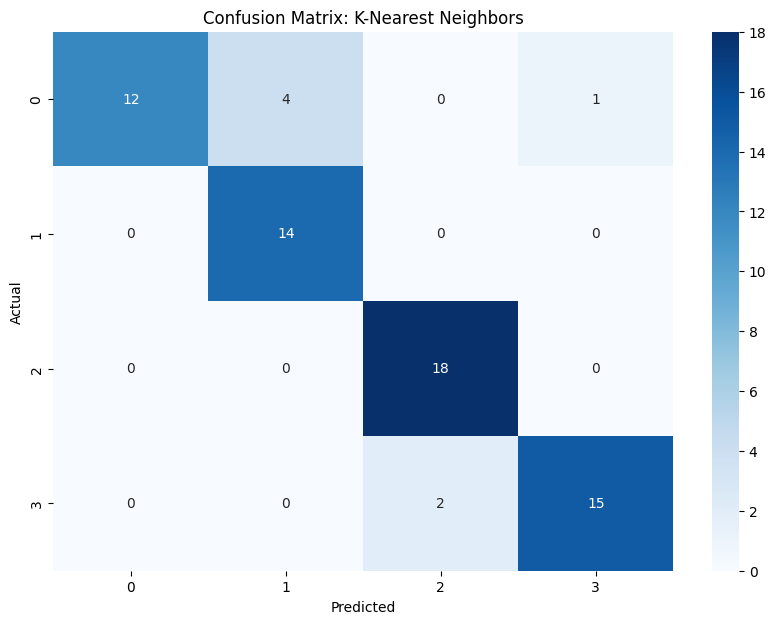



Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        17

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Accuracy: 1.0


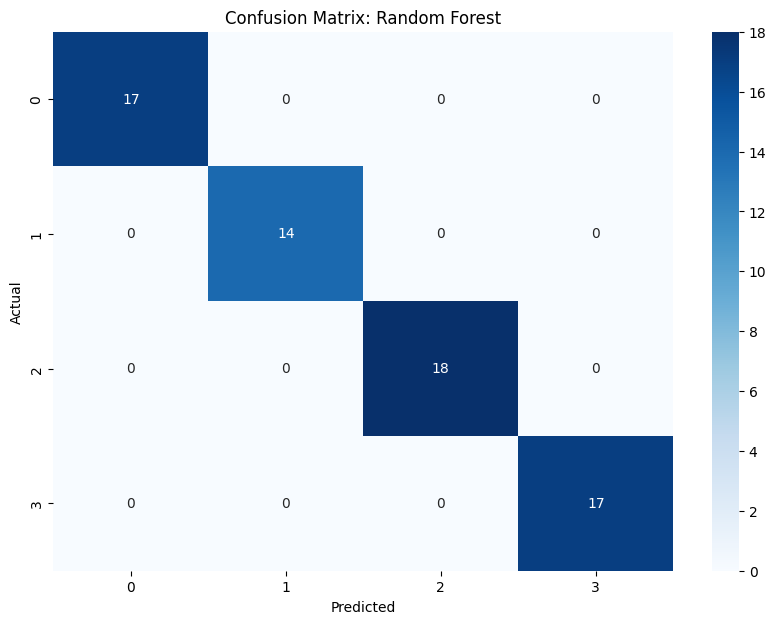





Resultados para Clima Extremo
Model: Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        29

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Accuracy: 1.0


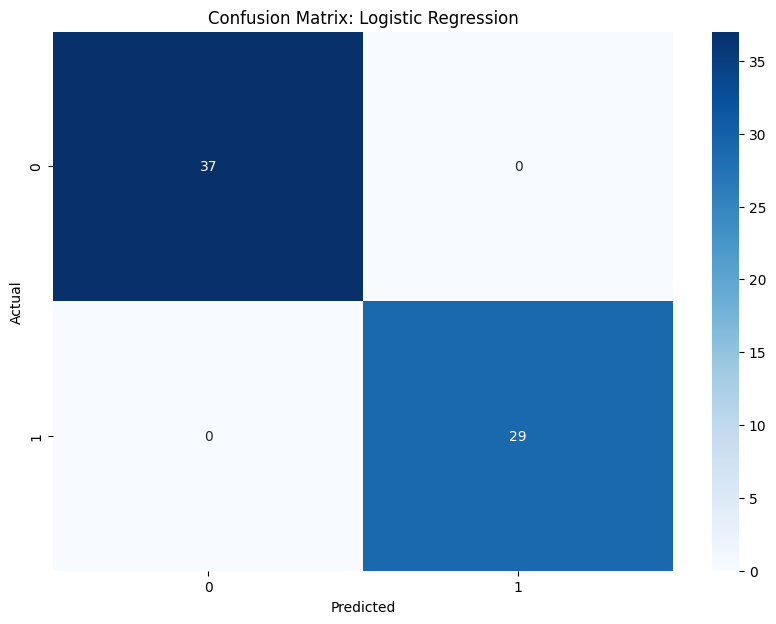



Model: K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        37
           1       0.93      0.97      0.95        29

    accuracy                           0.95        66
   macro avg       0.95      0.96      0.95        66
weighted avg       0.96      0.95      0.95        66

Accuracy: 0.9545454545454546


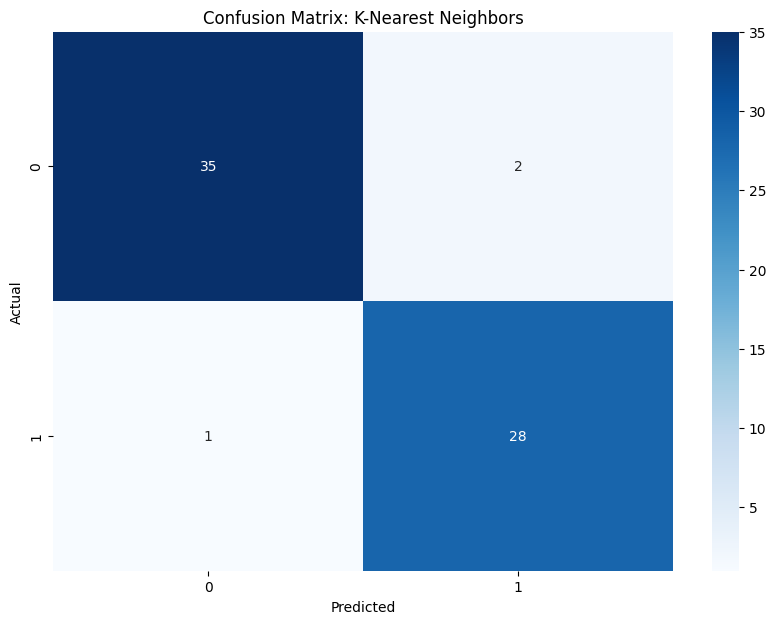



Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        29

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Accuracy: 1.0


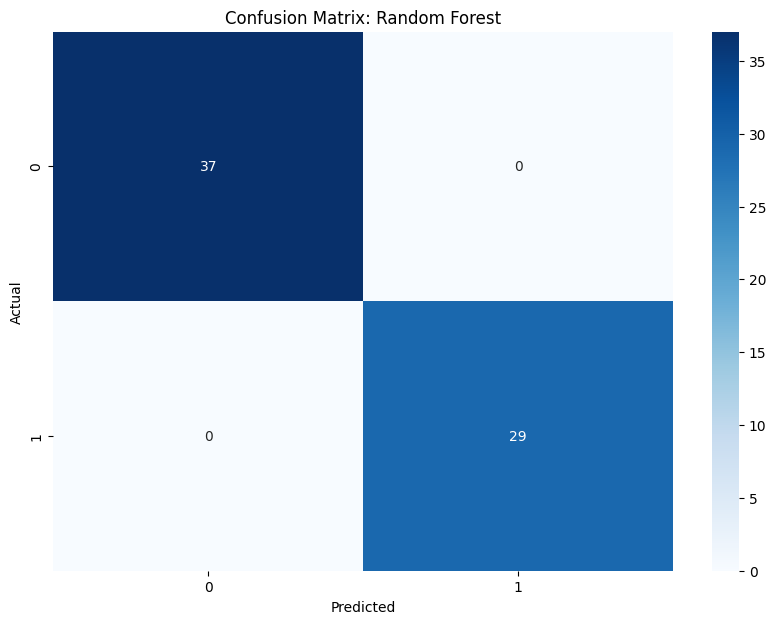





Resultados para Incendios Forestales
Model: Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        27

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Accuracy: 1.0


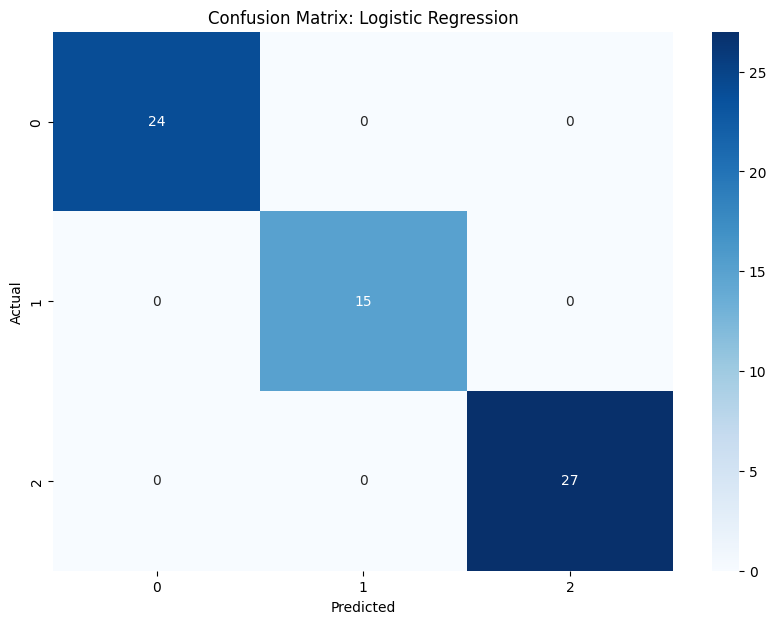



Model: K-Nearest Neighbors
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        27

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Accuracy: 1.0


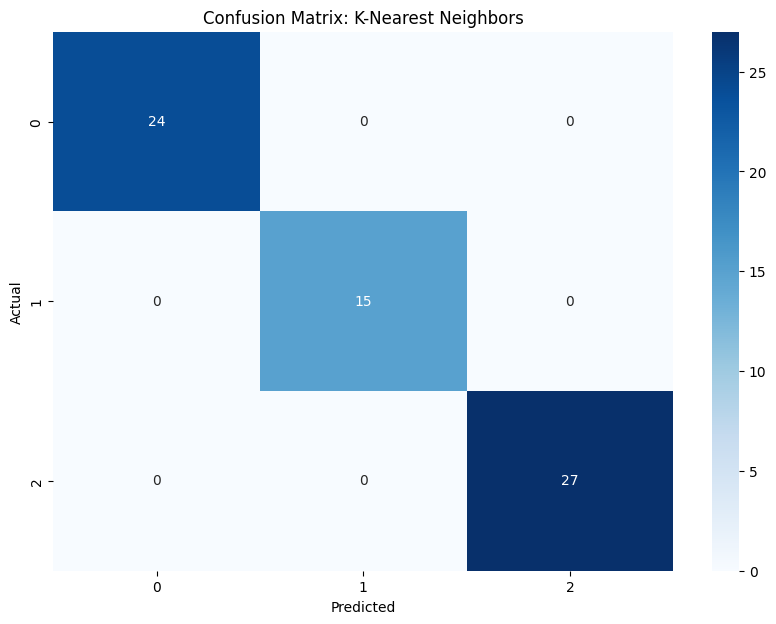



Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        27

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Accuracy: 1.0


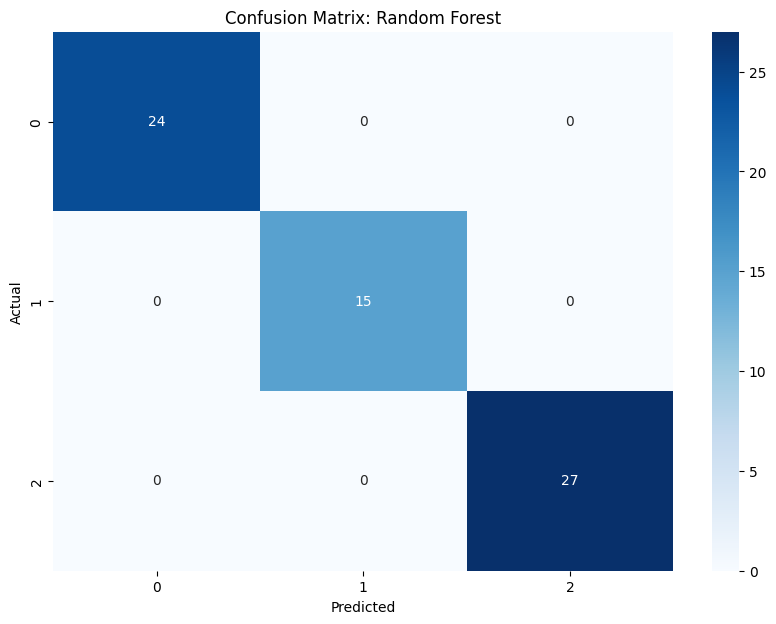





Resultados para Sequías
Model: Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        19

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Accuracy: 1.0


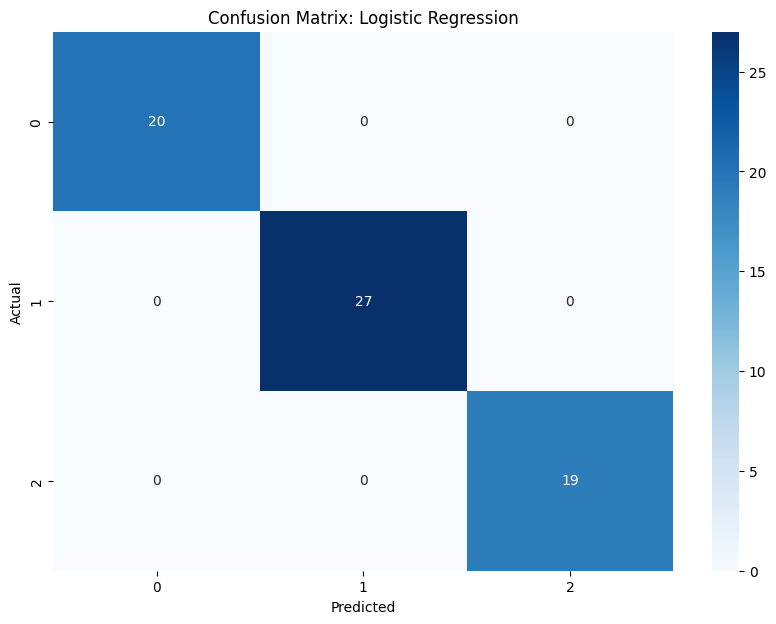



Model: K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      1.00      1.00        27
           2       1.00      0.95      0.97        19

    accuracy                           0.98        66
   macro avg       0.98      0.98      0.98        66
weighted avg       0.99      0.98      0.98        66

Accuracy: 0.9848484848484849


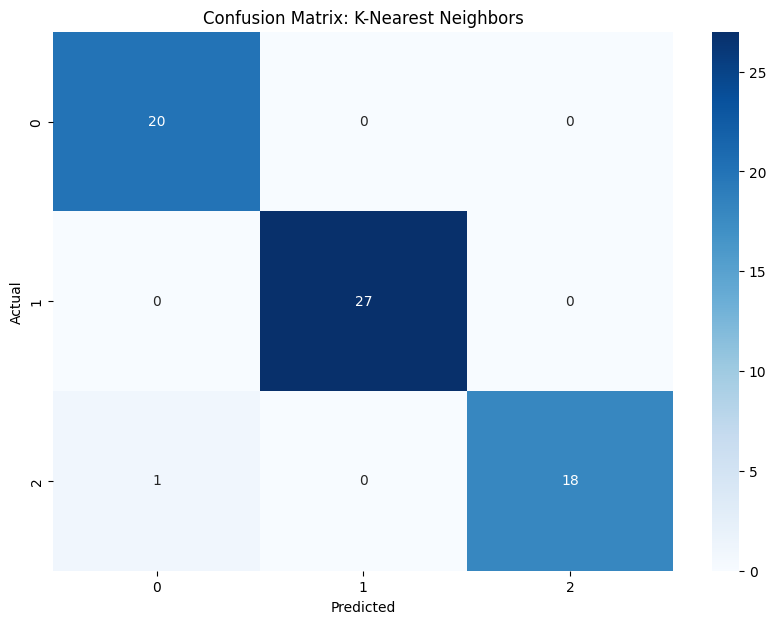



Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        19

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Accuracy: 1.0


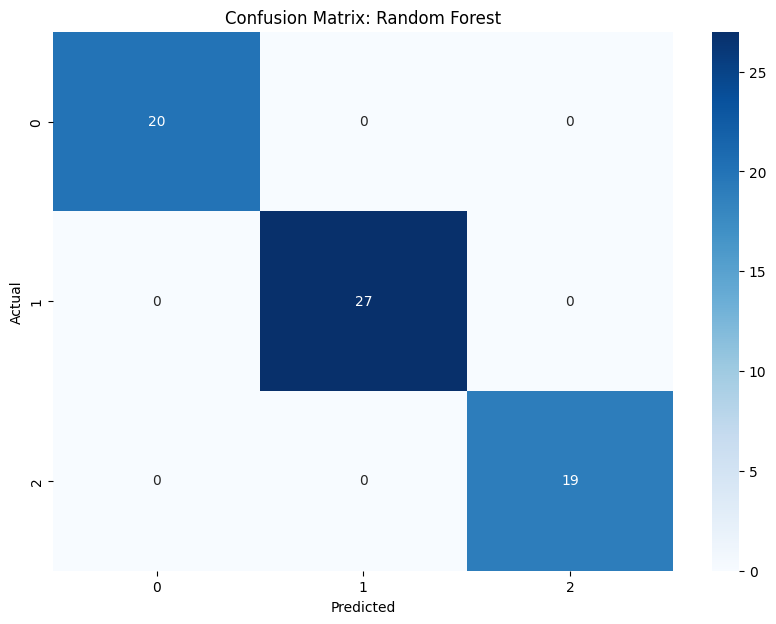





Resultados para Sismos
Model: Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        34
           1       0.94      1.00      0.97        32

    accuracy                           0.97        66
   macro avg       0.97      0.97      0.97        66
weighted avg       0.97      0.97      0.97        66

Accuracy: 0.9696969696969697


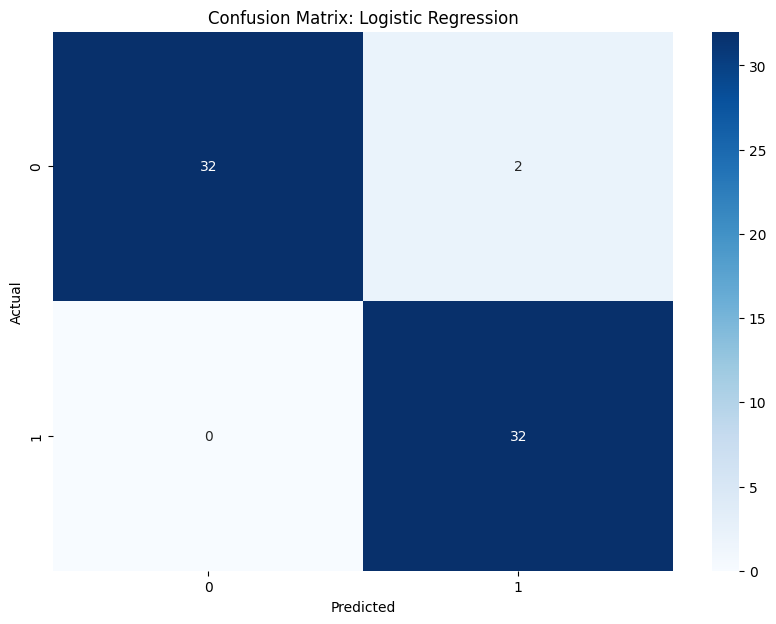



Model: K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        34
           1       0.94      0.97      0.95        32

    accuracy                           0.95        66
   macro avg       0.95      0.95      0.95        66
weighted avg       0.96      0.95      0.95        66

Accuracy: 0.9545454545454546


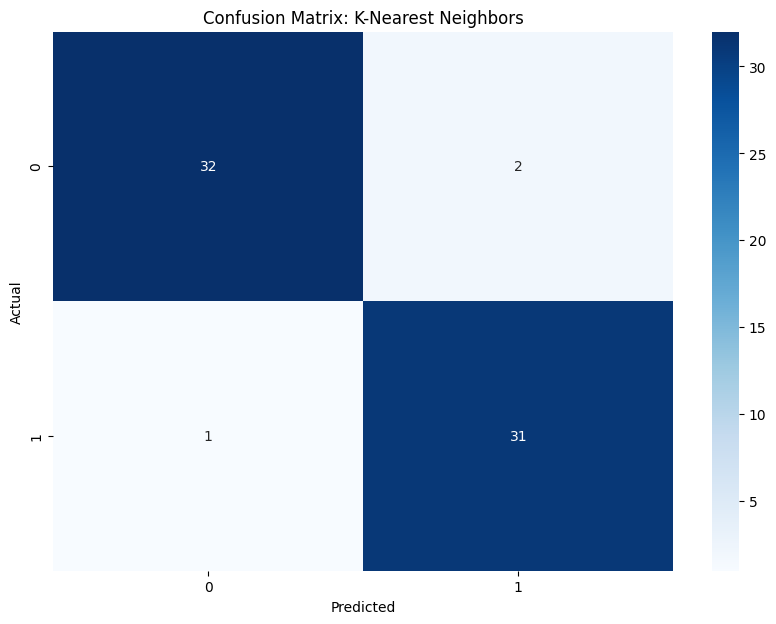



Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        32

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66

Accuracy: 1.0


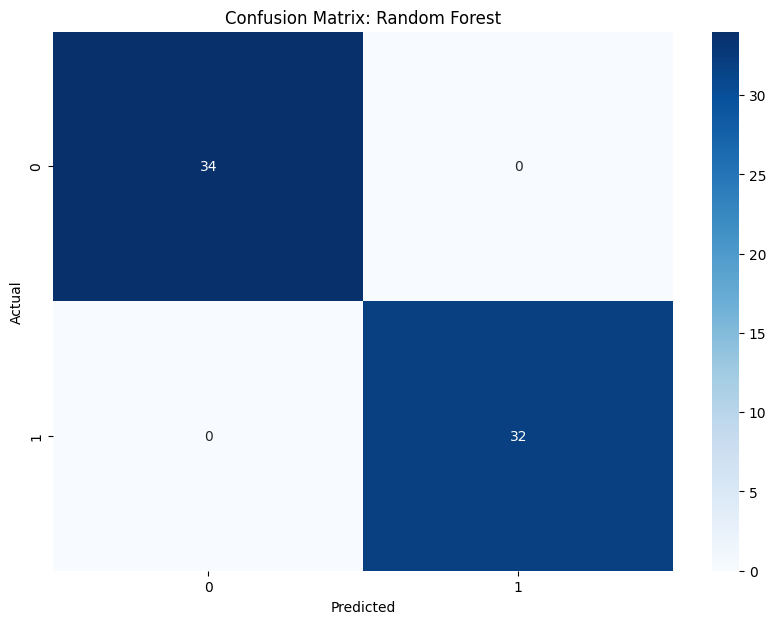

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Función para plotear la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Función para clasificar, evaluar y plotear
def classify_evaluate_and_plot(X_train, X_test, y_train, y_test):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Random Forest": RandomForestClassifier()
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Model: {name}")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
        plot_confusion_matrix(y_test, y_pred, title=f'Confusion Matrix: {name}')
        print("\n")

# Preprocesar, clasificar, evaluar y plotear los datasets balanceados
for name, df in balanced_datasets_final.items():
    print(f"Resultados para {name}")
    X_train, X_test, y_train, y_test = preprocess_data(df, 'Gravedad')
    classify_evaluate_and_plot(X_train, X_test, y_train, y_test)
    print("\n")


Frecuencias de Clases para Ciclones


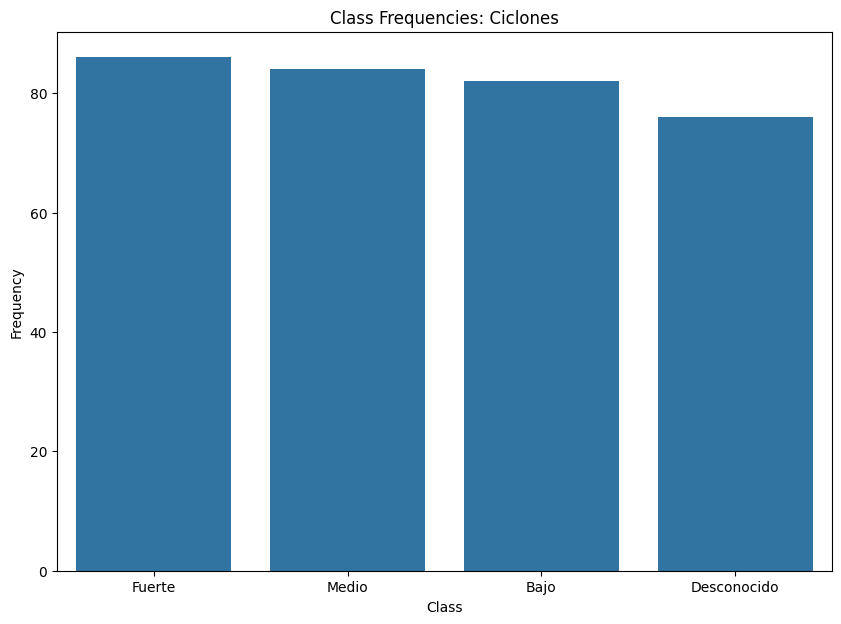



Frecuencias de Clases para Clima Extremo


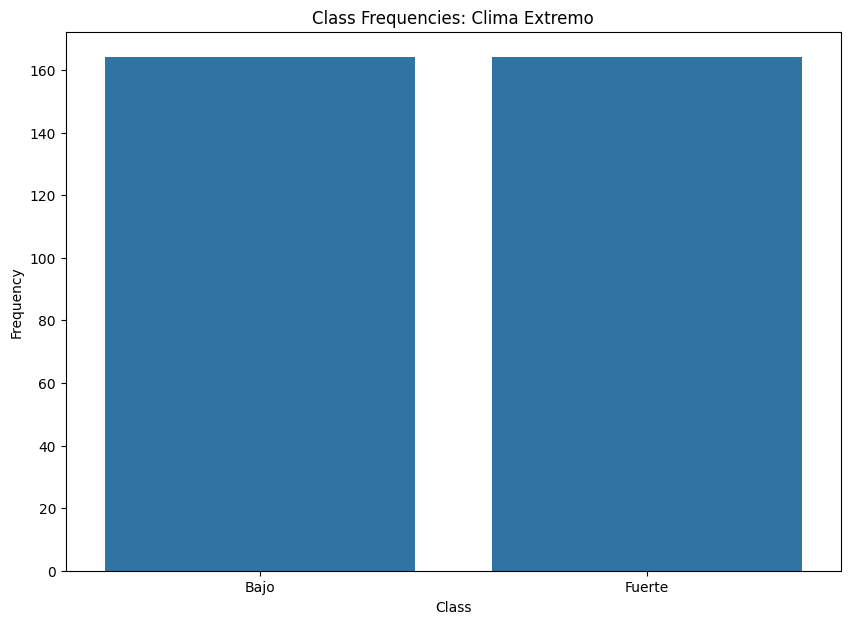



Frecuencias de Clases para Incendios Forestales


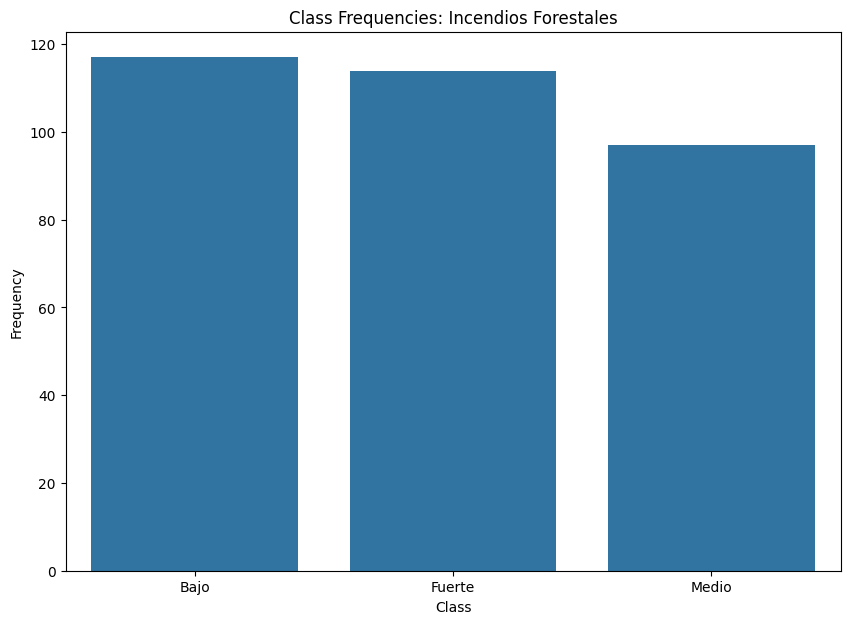



Frecuencias de Clases para Sequías


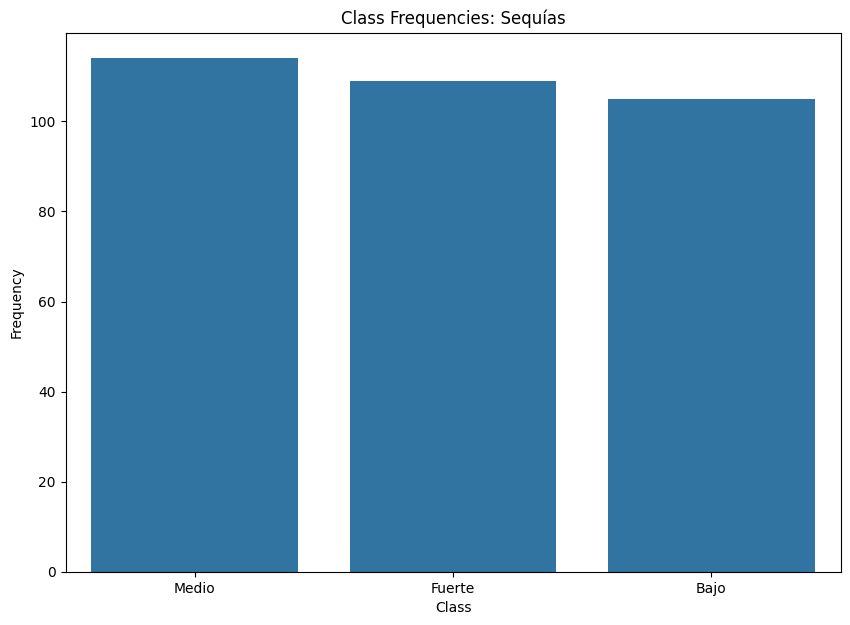



Frecuencias de Clases para Sismos


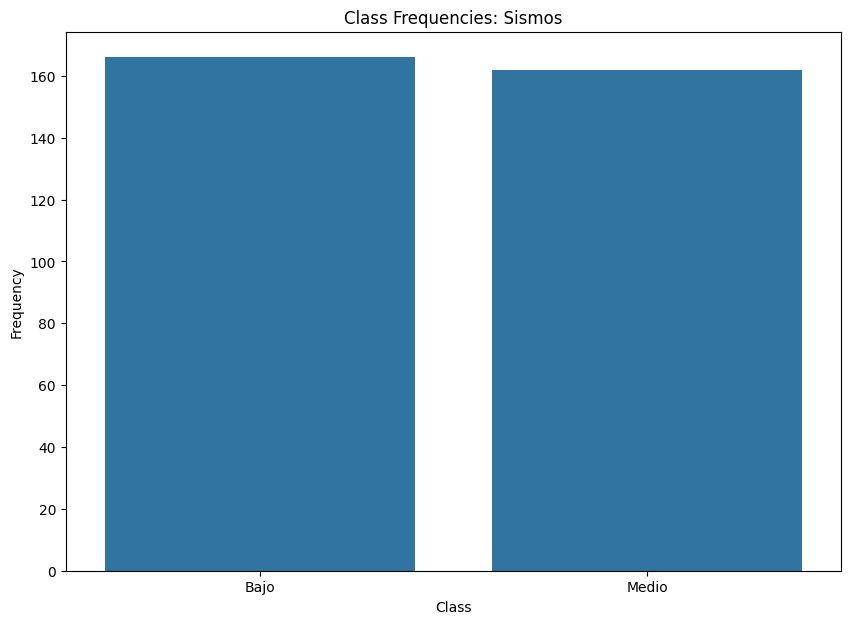

In [ ]:
# Función para plotear las frecuencias de las clases de gravedad
def plot_class_frequencies(df, class_column, title='Class Frequencies'):
    plt.figure(figsize=(10, 7))
    sns.countplot(data=df, x=class_column, order=df[class_column].value_counts().index)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

# Plotear las frecuencias de las clases para los datasets balanceados
for name, df in balanced_datasets_final.items():
    print(f"Frecuencias de Clases para {name}")
    plot_class_frequencies(df, 'Gravedad', title=f'Class Frequencies: {name}')
    print("\n")


In [67]:
!pip install pyshp

In [69]:
# Mostrar los nombres de los campos en el shapefile
fields = [field[0] for field in sf.fields[1:]]  # La primera entrada no es un campo
print(fields)

['CVE_ENT', 'NOM_ENT', 'CVE_CAP', 'NOM_CAP', 'AREA', 'PERIMETER', 'COV_', 'COV_ID']


['CVE_ENT', 'NOM_ENT', 'CVE_CAP', 'NOM_CAP', 'AREA', 'PERIMETER', 'COV_', 'COV_ID']


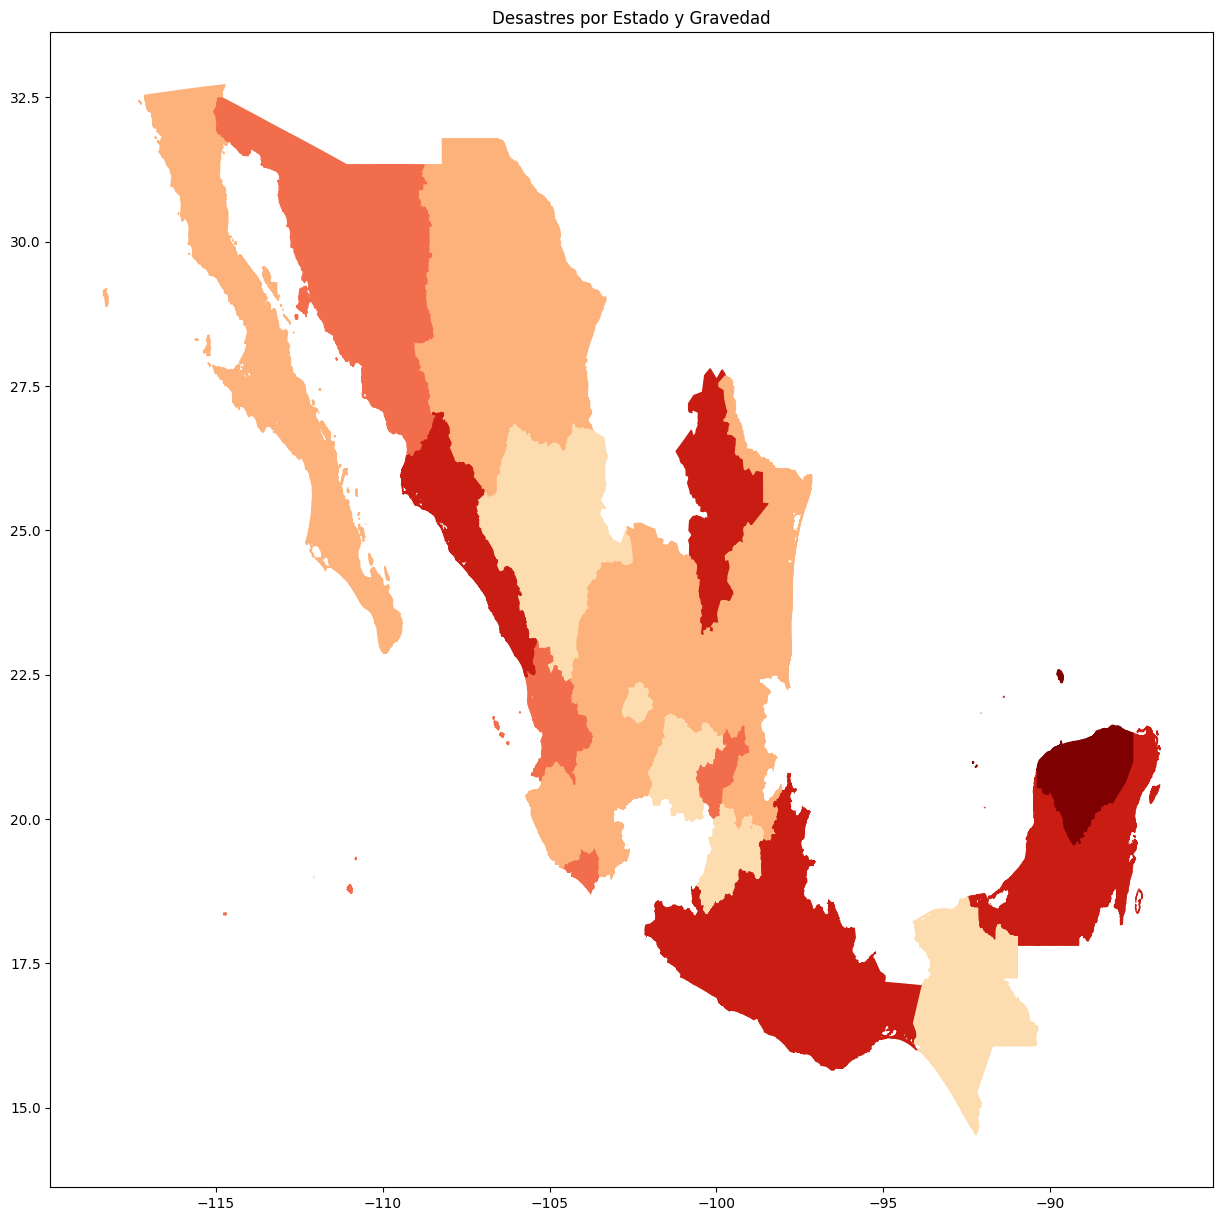

In [72]:
import shapefile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# archivo shapefile
shapefile_path = '/content/drive/My Drive/CIP/ESTADOS.shp'

# Leer el shapefile usando PyShp
sf = shapefile.Reader(shapefile_path)

# Extraer las formas y registros
shapes = sf.shapes()
records = sf.records()

# Mostrar los nombres de los campos en el shapefile
fields = [field[0] for field in sf.fields[1:]]
print(fields)

# Crear un DataFrame de ejemplo para desastres, asegurando que los nombres de los estados coincidan
data = {
    'Estado': [
        'Aguascalientes', 'Baja California', 'Baja California Sur', 'Campeche', 'Coahuila',
        'Colima', 'Chiapas', 'Chihuahua', 'Ciudad de México', 'Durango', 'Guanajuato',
        'Guerrero', 'Hidalgo', 'Jalisco', 'México', 'Michoacán', 'Morelos',
        'Nayarit', 'Nuevo León', 'Oaxaca', 'Puebla', 'Querétaro', 'Quintana Roo',
        'San Luis Potosí', 'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas', 'Tlaxcala',
        'Veracruz', 'Yucatán', 'Zacatecas'
    ],
    'Gravedad': np.random.randint(1, 6, size=32)  # Gravedad aleatoria entre 1 y 5
}
df = pd.DataFrame(data)

# Crear un mapa coloreado según la gravedad (relleno)
fig, ax = plt.subplots(figsize=(15, 15))

# Dibujar cada estado
for shapeRec in sf.shapeRecords():
    shape = shapeRec.shape
    record = shapeRec.record
    estado_name = record[fields.index('NOM_ENT')]  # Ajustar al nombre del campo correcto
    if estado_name in df['Estado'].values:
        gravedad = df[df['Estado'] == estado_name]['Gravedad'].values[0]
        color = plt.cm.OrRd(gravedad / df['Gravedad'].max())  # Ajustar la escala de colores
    else:
        color = 'white'

    points = shape.points
    parts = shape.parts
    parts.append(len(points))

    for i in range(len(parts) - 1):
        part_points = points[parts[i]:parts[i + 1]]
        x = [p[0] for p in part_points]
        y = [p[1] for p in part_points]
        ax.fill(x, y, color=color)

# Configurar título y mostrar la figura
ax.set_title('Desastres por Estado y Gravedad')
plt.show()

